# iris tomography codes and other stuff

In [1]:
import sqlite3 as sql
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

## import data from database

In [2]:
orbit = 20900
num_of_orbits = 1
ch = 3

db = sql.connect('../OSIRIS_three_orbits_test.db')
cur = db.cursor()

return_column = ('data, mjd, look_ecef, sc_position_ecef, latitude, longitude, altitude')              
select_str = 'SELECT {} FROM IRI JOIN channel{} ON IRI.stw = channel{}.stw WHERE orbit>={} AND orbit<={}'
result = cur.execute(select_str.format(return_column, ch, ch, orbit, orbit+num_of_orbits))
all_image = result.fetchall()
db.close()

if len(all_image) == 0:
    print('No data for this orbit(s)')    
print('num of images: {}'.format(len(all_image)))

l1_blob = np.array(all_image)[:,0]
mjd = np.array(all_image)[:,1].astype(float)
date = num2date(mjd, units)
sc_look_blob = np.array(all_image)[:,2]
sc_pos_blob = np.array(all_image)[:,3]
tan_lat_blob = np.array(all_image)[:,4]
tan_lon_blob = np.array(all_image)[:,5]
tan_alt_blob = np.array(all_image)[:,6]

#====unfolding blobs
l1 = np.empty((len(all_image),128))
sc_look = np.empty((len(all_image), 128, 3))
sc_pos = np.empty((len(all_image), 3))
tan_lat = np.empty((len(all_image),128))
tan_lon = np.empty((len(all_image),128))
tan_alt = np.empty((len(all_image),128))
for i in range(len(all_image)):
    l1[i,:] = np.frombuffer(l1_blob[i])
    sc_look[i,:,:] = np.frombuffer(sc_look_blob[i]).reshape(128,3)
    sc_pos[i,:] = np.frombuffer(sc_pos_blob[i])
    tan_lat[i,:] = np.frombuffer(tan_lat_blob[i])
    tan_lon[i,:] = np.frombuffer(tan_lon_blob[i])
    tan_alt[i,:] = np.frombuffer(tan_alt_blob[i])
#====construct xarray data array
pixel = np.arange(128)
l1 = xr.DataArray(l1, coords=(date, pixel), 
                  dims=('date', 'pixel'), 
                  attrs={'units':'Rayleigh??'})
sc_look = xr.DataArray(sc_look, coords=(date, pixel, ['x', 'y', 'z']), 
                       dims=('date', 'pixel', 'xyz'))
sc_pos = xr.DataArray(sc_pos, coords=(date, ['x', 'y', 'z']), 
                      dims=('date', 'xyz'))
tan_lat = xr.DataArray(tan_lat, coords=(date, pixel),
                       dims=('date', 'pixel'), 
                       attrs={'units':'degree'})
tan_lon = xr.DataArray(tan_lon, coords=(date, pixel),
                       dims=('date', 'pixel'), 
                       attrs={'units':'degree'})
tan_alt = xr.DataArray(tan_alt, coords=(date, pixel),
                       dims=('date', 'pixel'), 
                       attrs={'units':'meter'})
import pandas as pd
from geometry_functions import lla2ecef
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), 
                     pd.Index(['x','y','z'], name='xyz'))

#====drop all dates which have nan in l1
l1 = l1.dropna('date')
sc_look = sc_look.sel(date=l1.dropna('date').date)
sc_pos = sc_pos.sel(date=l1.dropna('date').date)
tan_lat = tan_lat.sel(date=l1.dropna('date').date)
tan_lon = tan_lon.sel(date=l1.dropna('date').date)
tan_alt = tan_alt.sel(date=l1.dropna('date').date)
date = l1.dropna('date').date.data
print('num of images after removing nan: {}'.format(len(date)))

num of images: 5792
num of images after removing nan: 4784


# check which data we are looking at

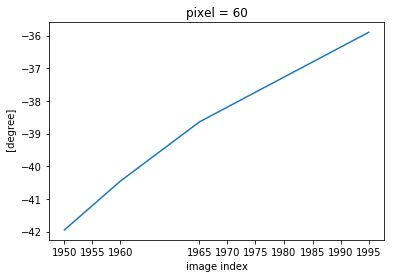

<Figure size 432x288 with 0 Axes>

/home/anqil/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


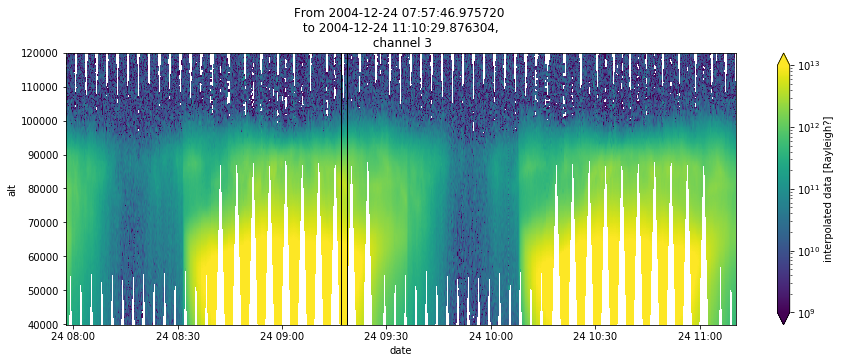

<Figure size 432x288 with 0 Axes>

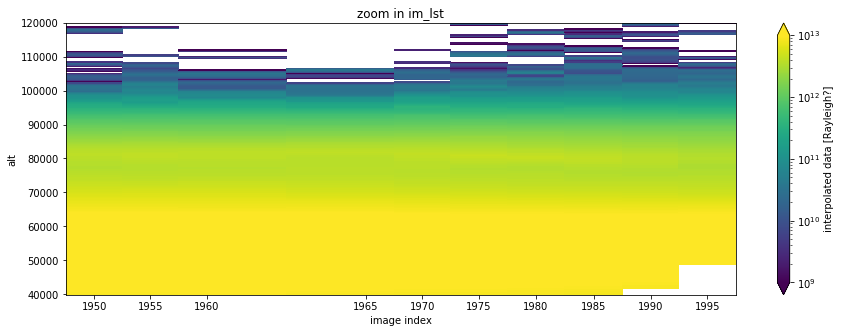

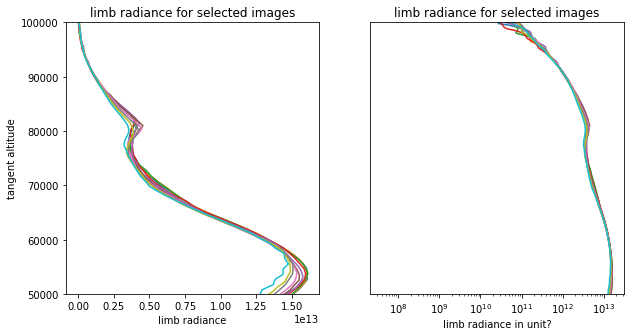

In [3]:
#====choose mesurements
im_lst = np.arange(1950,2000, 5) # dayglow ex
#im_lst = np.arange(2000,2050, 5) # datglow doesnt work (scanning)
#im_lst = np.arange(500,550, 5) #nightglow ex
pix_lst = np.arange(22,128)

tan_lat.isel(date=im_lst, pixel=60).plot()
ax = plt.gca()
ax.set_xticks(date[im_lst])
ax.set_xticklabels(im_lst)
ax.set(xlabel='image index')
plt.show()


alts_interp = np.arange(40e3, 120e3, .25e3)
data_interp = []

for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, 
                           coords=(date, alts_interp), 
                           dims=('date', 'alt'))
data_interp.attrs['units'] = 'Rayleigh?'
data_interp.attrs['long_name'] = 'interpolated data'

#==== plot something
plt.figure()
data_interp.plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='From {} \n to {}, \n channel {}'.format(num2date(mjd[0],units),
       num2date(mjd[-1], units), ch))
plt.axvline(x=date[im_lst[0]], color='k', linewidth=1)
plt.axvline(x=date[im_lst[-1]], color='k', linewidth=1)
plt.show()

plt.figure()
data_interp.isel(date=im_lst).plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst',
      xlabel='image index')
ax.set_xticks(date[im_lst])
ax.set_xticklabels(im_lst)
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])

plt.subplot(122)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(xlabel='limb radiance in unit?',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])
ax.set_xscale('log')
plt.yticks([])
plt.show()

# change coordinate to across- along-track and define atmospheric grid

In [4]:
#====define the new base vectors
n_crosstrack = np.cross(sc_look.isel(date=im_lst[0], pixel=60),
                        sc_pos.isel(date=im_lst[0]))
n_vel = np.cross(sc_pos.isel(date=im_lst[0]), n_crosstrack)
n_zenith = sc_pos.isel(date=im_lst[0])

#====tangent points in alpha, beta, rho coordinate
import pandas as pd
from geometry_functions import lla2ecef, cart2sphe, change_of_basis
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), 
                     pd.Index(['x','y','z'], name='xyz'))

tan_alpha = []
tan_beta = []
tan_rho = []
for i in im_lst:
    p_old = tan_ecef.isel(date=i, pixel=pix_lst)
    p_new = change_of_basis(n_crosstrack, n_vel, n_zenith, p_old)
    alpha, beta, rho = cart2sphe(p_new.sel(xyz='x'),
                                 p_new.sel(xyz='y'),
                                 p_new.sel(xyz='z'))
    tan_alpha.append(alpha)
    tan_beta.append(beta)
    tan_rho.append(rho)
tan_alpha = xr.DataArray(tan_alpha, 
                         coords=[date[im_lst], pixel[pix_lst]],
                         dims=['date', 'pixel'])
tan_beta = xr.DataArray(tan_beta, 
                        coords=[date[im_lst], pixel[pix_lst]],
                        dims=['date', 'pixel'])
tan_rho = xr.DataArray(tan_rho, 
                       coords=[date[im_lst], pixel[pix_lst]],
                       dims=['date', 'pixel'])

#====define atmosphere grid (the bin edges)
edges_alpha = np.linspace(tan_alpha.min()-0.01,
                          tan_alpha.max()+0.01, 2) #radian
edges_beta = np.linspace(tan_beta.min()-0.1,
                         tan_beta.max()+0.1, 15) #radian
edges_rho = np.arange(25e3, 175e3, 2e3) # meter
edges = edges_alpha, edges_beta, edges_rho

# build tomo jacobian for the chosen images and pixels

In [5]:
#====num of columns & rows of jacobian
col_len = (len(edges_alpha)+1)*(len(edges_beta)+1)*(len(edges_rho)+1) 
row_len = len(im_lst) * len(pix_lst)

#====measure pathlength in each bin
from geometry_functions import los_points_fix_dl
from oem_functions import jacobian_row

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp
all_los_alpha, all_los_beta, all_los_rho = [], [], []
measurement_id = 0
for image in im_lst:
    #====generate points of los for all pixels in each image
    #====all points in cartesian coordinate relative to the space craft
    sc_look_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                  sc_look[image].T)
    sc_pos_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                 sc_pos[image])
    lx, ly, lz = los_points_fix_dl(sc_look_new, sc_pos_new, dl=dl, nop=nop)    
    #====convert xyz to alpha, beta, rho for all points
    los_alpha, los_beta, los_rho = cart2sphe(lx, ly, lz)
    all_los_alpha.append(los_alpha)
    all_los_beta.append(los_beta)
    all_los_rho.append(los_rho)
    
    #====build K
    for pix in pix_lst:#range(pix_start, pix_end):   
        los = los_alpha.sel(pixel=pix), los_beta.sel(pixel=pix), los_rho.sel(pixel=pix)
        measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
        K_row_idx.append(measurement_idx)
        K_col_idx.append(grid_idx)
        K_value.append(pathlength)
        measurement_id += 1
        
        
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) # in meter

#==== create sparse matrix
from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))
#print(K_coo)

# Tomo (MAP/OEM) inversion

In [6]:
from oem_functions import linear_oem_sp
import scipy.sparse as sp
y = l1.isel(date=im_lst, pixel=pix_lst).data.ravel()
y[y<0] = 0
xa = np.ones(col_len) # temp
Sa = sp.diags([1], shape=(col_len, col_len)) *1 #temp
Se = sp.diags([1], shape=(measurement_id, measurement_id)) * 1e10 #temporary
x_hat, G = linear_oem_sp(K_coo, Se, Sa, y, xa)

result_tomo = x_hat.reshape(len(edges_alpha)+1, len(edges_beta)+1, len(edges_rho)+1)
result_tomo = xr.DataArray(result_tomo[1:,1:,1:], 
                           coords=(edges_alpha, edges_beta, edges_rho), 
                           dims=('alpha', 'beta', 'rho')) #temp

# Plot some (tomo) restuls


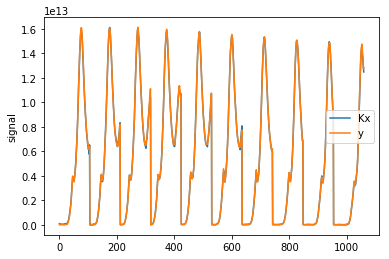

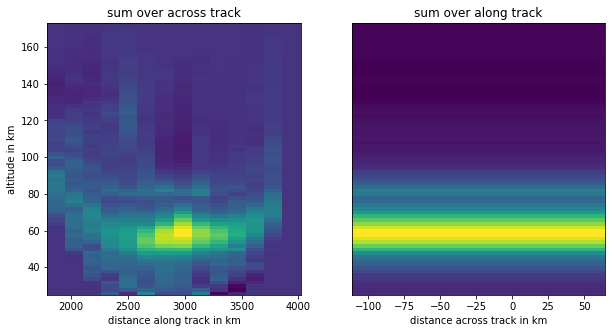

<Figure size 720x360 with 0 Axes>

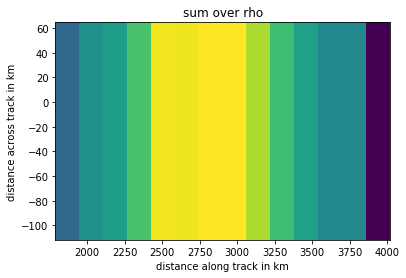

<Figure size 432x288 with 0 Axes>

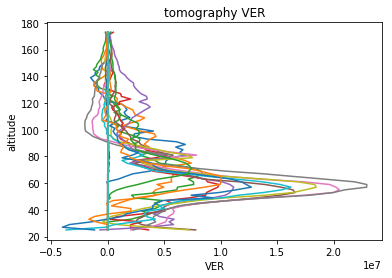

In [7]:
%matplotlib inline
#====check residual
plt.figure()
plt.plot(K_coo.dot(x_hat), label='Kx')
plt.plot(y, label='y')
plt.ylabel('signal')
plt.legend()
plt.show()

#====contour plot 
Re = 6371 + 100 #in km

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.pcolor(edges_beta*Re, edges_rho*1e-3, result_tomo.sum(axis=0).T)
plt.xlabel('distance along track in km')
plt.ylabel('altitude in km')
plt.title('sum over across track')

plt.subplot(122)
plt.pcolor(edges_alpha*Re, edges_rho*1e-3, result_tomo.sum(axis=1).T)
plt.xlabel('distance across track in km')
#plt.ylabel('altitude')
plt.title('sum over along track')
plt.yticks([])
plt.show()

plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.pcolor(edges_beta*Re, edges_alpha*Re, result_tomo.sum(axis=2))
ax.axis('normal')
plt.ylabel('distance across track in km')
plt.xlabel('distance along track in km')
plt.title('sum over rho')
plt.show()

plt.figure()
fig, ax = plt.subplots()
ax.set_xscale('linear')
ax.set(xlabel='VER',
      ylabel='altitude',
      title='tomography VER')
for i in range(len(edges_alpha)):
    for j in range(len(edges_beta)):
        ax.plot(result_tomo[i,j,:], edges_rho*1e-3, '-')


# check averaging kernel (tomo)

mreasurement response of grid 1856 1.3033404929545256


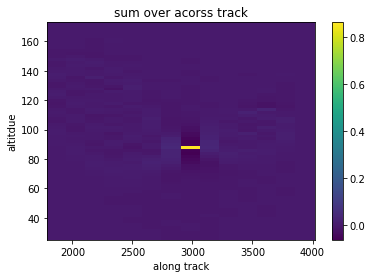

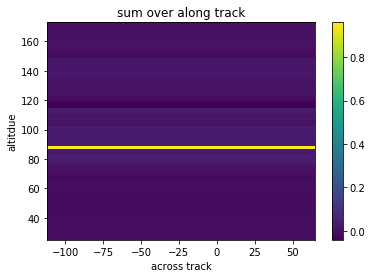

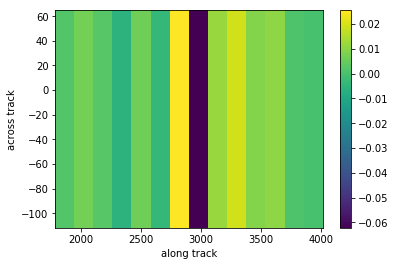

In [8]:
A = G.dot(K_coo)
alpha_id = round((len(edges_alpha))/2)
beta_id = round((len(edges_beta))/2)
shape = (len(edges_alpha)+1, len(edges_beta)+1, len(edges_rho)+1)
grid_id = np.ravel_multi_index((alpha_id, beta_id, 32), shape)
A_row = A[grid_id,:]
AAA = A_row.toarray().squeeze().reshape(len(edges_alpha)+1, 
                                        len(edges_beta)+1, 
                                        len(edges_rho)+1)
plt.pcolor(edges_beta*Re, edges_rho*1e-3, AAA[1:, 1:, 1:].sum(axis=0).T)
plt.title('sum over acorss track')
plt.xlabel('along track')
plt.ylabel('altitdue')
plt.colorbar()

plt.figure()
plt.pcolor(edges_alpha*Re, edges_rho*1e-3, AAA[1:, 1:, 1:].sum(axis=1).T)
plt.title('sum over along track')
plt.xlabel('across track')
plt.ylabel('altitdue')
plt.colorbar()


plt.figure()
plt.pcolor(edges_beta*Re, edges_alpha*Re, AAA[1:, 1:, 30])
plt.xlabel('along track')
plt.ylabel('across track')
plt.colorbar()

print('mreasurement response of grid {}'.format(grid_id), AAA.sum()) #measurement response


# 1D inversion

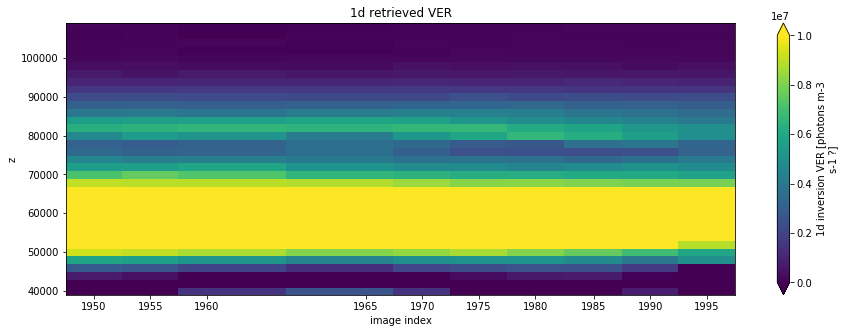

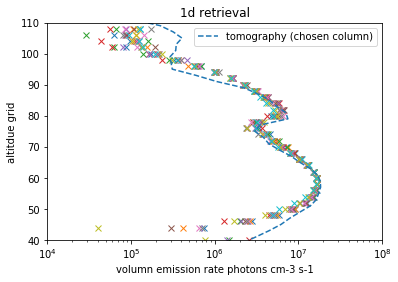

In [36]:
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris

z = np.arange(40e3, 110e3, 2e3) # m
z_top = z[-1] + 2e3
result_1d = np.zeros((len(im_lst), len(z)))
xa = np.ones(len(z)) # temp
Sa = np.diag(np.ones(len(z))) *1e-9 #temp
Se = np.diag(np.ones(len(pixel))) * 30# 1e10 #30 #temporary
for i in range(len(im_lst)):
    h = tan_alt.isel(date=im_lst[i]).data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(date=im_lst[i]).data    
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
#    plt.plot(y, np.arange(128))
#    plt.plot(K.dot(x), np.arange(128))

result_1d = xr.DataArray(result_1d, coords=(date[im_lst], z), dims=('date', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'

# plot VER results
result_1d.plot(x='date', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=1e7, 
         size=5, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER',
      xlabel='image index')
ax.set_xticks(date[im_lst])
ax.set_xticklabels(im_lst)

plt.figure()
plt.plot(result_1d.T, z*1e-3, 'x')
ax = plt.gca()
ax.set_xscale('log')
ax.set(xlim=[1e4, 1e8],
       ylim=[40, 110],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')

ax.plot(result_tomo[alpha_id-1, beta_id,:].T, edges_rho*1e-3,
        '--', label='tomography (chosen column)')
plt.legend()


# Ozone calculation

In [11]:
from chemi import ozone_sme, ozone_textbook, oxygen_atom, jfactors, gfactor
from scipy.io import loadmat
import sys
sys.path.append('..')

Text(0.5, 1.0, 'gA')

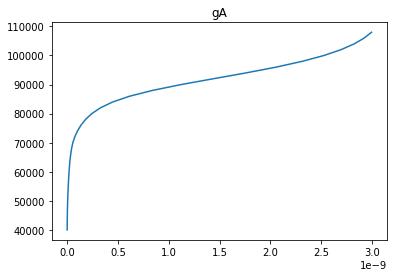

In [12]:
MSIS = loadmat('../msisdata.mat')
zMsis = MSIS['zMsis'].squeeze() # in km
TMsis = MSIS['TMsis'] # in K
NMsis = MSIS['NMsis'] # in cm-3 ???
monthMsis = MSIS['monthMsis'].squeeze()
latMsis = MSIS['latMsis'].squeeze()
month = 6 #temp
lat = 1 #temp
T = interp1d(zMsis*1e3, TMsis[:,month,lat], fill_value='extrapolate')(z)
M = interp1d(zMsis*1e3, NMsis[:,month,lat], fill_value='extrapolate')(z)

#calculate O2 photosythesis rate first
zenithangle = 10
gA = gfactor(0.2*M, T, z, zenithangle)
plt.plot(gA,z)
plt.title('gA')

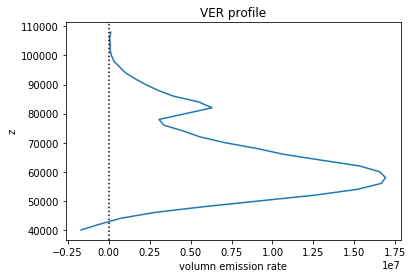

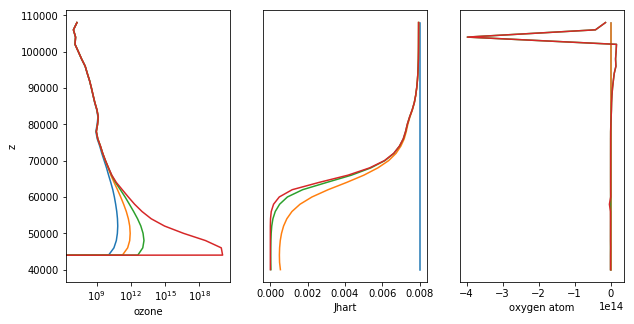

In [38]:
#ver profile to be calculated to ozone
plt.figure()
plt.plot(result_1d[0],z, '-')
plt.axvline(x=0, linestyle=':', color='k')
plt.title('VER profile')
plt.xlabel('volumn emission rate')
plt.ylabel('z')

#==== iterations
plt.figure(figsize=(10, 5))
ax0 = plt.subplot(131)
ax1 = plt.subplot(132)
ax2 = plt.subplot(133)
ax1.set_yticks([])
ax2.set_yticks([])
ax0.set(xlabel='ozone', 
        ylabel='z')#,
#        xlim=[0, 1e11])
ax0.set_xscale('log')
ax1.set(xlabel='Jhart')
ax2.set(xlabel='oxygen atom')

#iter 1 (constant Jhart)
o3 = ozone_sme(M, T, result_1d[0], jhart=8e-3, js=gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=8e-3)
ax0.plot(o3,z, label='1')
ax1.plot(8e-3 * np.ones(z.shape), z, label='1')
ax2.plot(0*np.ones(z.shape), z, label='1')


#iter 2 (calculate Jhart with 0 oxygen atom)
jhart, jsrc, jlya, j3, j2 = jfactors(O=0*M, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='2')
ax1.plot(jhart, z, label='2')
ax2.plot(0*np.ones(z.shape), z, label='2')


#iter 3 (calculate Jhart with some oxygen atom)
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=0*M, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='3')
ax1.plot(jhart, z, label='3')
ax2. plot(o, z, label='3')


#iter 4
o = oxygen_atom(M, T, o3, j3)
jhart, jsrc, jlya, j3, j2 = jfactors(O=0*M, O2=0.2*M, O3=o3.data, N2=0.8*M, z=z, zenithangle=zenithangle)
o3 = ozone_sme(M, T, result_1d[0], jhart, gA)
#o3 = ozone_textbook(M, T, result_1d[0], jhart=jhart)
ax0.plot(o3,z, label='4')
ax1.plot(jhart, z, label='4')
ax2. plot(o, z, label='4')

